https://www.kaggle.com/crowdflower/twitter-airline-sentiment

#### Import modules

In [1]:
%matplotlib inline

In [2]:
try:
    from IPython.display import display
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import os, sys, urllib
    from zipfile import ZipFile
    
    from time import time
    from sklearn.utils import class_weight as cw
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

    from keras.models import Model
    from keras.layers import Dense, Input, Dropout, LSTM, Activation, BatchNormalization
    from keras.layers.embeddings import Embedding
    from keras.preprocessing import sequence
    from keras.initializers import glorot_uniform

except:
    !pip install -r requirements.txt > /dev/null
    !python -m nltk.downloader stopwords > /dev/null
    
np.random.seed(0)

Using TensorFlow backend.


In [3]:
tweets=pd.read_csv('Tweets_preprocess.csv', index_col=0)

In [4]:
labels=['positive', 'neutral', 'negative']

In [5]:
train_X, test_X, train_Y, test_Y=train_test_split(tweets['text_clean'], tweets['sentiment'], test_size=0.1)

In [6]:
train_X.shape, train_Y.shape

((13176,), (13176,))

In [7]:
test_X.shape, test_Y.shape

((1464,), (1464,))

In [8]:
maxLen = len(max(train_X, key=len).split())

# 4. Model - RNN

## 4.1 Load pre-trained word embedding 
Because word embeddings are very computionally expensive to train, I will use 50-dimensional GloVe vectors to represent words. It is a pre-trained set of word embeddings

**References to**:
- The GloVe word embeddings were due to Jeffrey Pennington, Richard Socher, and Christopher D. Manning. (https://nlp.stanford.edu/projects/glove/)
- Deep Learning, Andrew Ng at Cousera (https://www.coursera.org/learn/nlp-sequence-models/home/week/2)

In [9]:
if not os.path.exists('glove.6B.50d.txt'):
    with ZipFile('glove.6B.50d.txt.zip', 'r') as zipObj:
        zipObj.extractall()

In [10]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [11]:
word_to_index, index_to_word, word_to_vec_map=read_glove_vecs('glove.6B.50d.txt')

In [12]:
print('The pre-trained set contains',len(word_to_index),'words')

The pre-trained set contains 400000 words


In [13]:
print('Each word is represend as a', word_to_vec_map['dummy'].shape[0], 'dimension vector')

Each word is represend as a 50 dimension vector


## 4.2 Preprocess

Convert each tweet to its glove-represented index list

In [14]:
def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]
    X_indices = np.zeros((m, max_len))
    
    for i in range(m): 
        sentence_words = [w.lower() for w in X[i].split()]
        j = 0
        for w in sentence_words:
            if w not in word_to_index:
                break
            X_indices[i, j] = word_to_index[w]
            j += 1

    return X_indices

In [15]:
def convert_to_one_hot(Y):
    return pd.get_dummies(Y)

In [16]:
train_X_indices=sentences_to_indices(train_X.values, word_to_index, maxLen)
test_X_indices=sentences_to_indices(test_X.values, word_to_index, maxLen)

train_Y_oh=convert_to_one_hot(train_Y)
test_Y_oh=convert_to_one_hot(test_Y)

In [17]:
get_class_weight=lambda x: cw.compute_class_weight('balanced', np.unique(x), x)
class_weight=get_class_weight(train_Y)

## 4.3 Build model

In [18]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index, trainable=False):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    """
    vocab_len = len(word_to_index) + 1 
    emb_dim = word_to_vec_map["dummy"].shape[0]
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable=trainable)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [20]:
def plot_history(history, c):
    plt.figure()
    
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    y1=history.history[c]
    y2=history.history['val_'+c]

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model '+c)
    plt.xlabel('epoch')
    plt.ylabel(c)
    plt.legend(legends, loc='upper left')
    plt.grid()
    plt.show()

In [21]:
def run(model, 
        train_X_indices=train_X_indices, train_Y_oh=train_Y_oh,
        labels=labels, **kwargs):
    start=time()
    model.compile(loss=kwargs['loss'], optimizer=kwargs['optimizer'], metrics=kwargs['metrics'])
    history=model.fit(train_X_indices, train_Y_oh, 
                    epochs=kwargs['epochs'], batch_size=kwargs['batch_size'], 
                    validation_split=kwargs['validation_split'], class_weight=kwargs['class_weight'])
    end=time()
    
    print('Model runs for:', end-start)
    return history, model

In [43]:
def evaluate(history, model,
            test_X_indices=test_X_indices, test_Y_oh=test_Y_oh):
    plot_history(history, 'loss')
    plot_history(history, 'acc')
    
    loss, acc=model.evaluate(test_X_indices, test_Y_oh)
    
    print("Test accuracy = ", acc)
    pred=model.predict(test_X_indices)
    pred=[*map(lambda x: test_Y_oh.columns[np.argmax(x)], pred)]
    print("Test f1 score = ", f1_score(test_Y, pred, average='weighted'))
    confusion=confusion_matrix(test_Y, pred, labels=labels)
    confusion = pd.DataFrame(confusion, index=labels,
                             columns=['predicted_'+l for l in labels])
    display(confusion)

In [23]:
params={
    'loss': 'categorical_crossentropy',
    'optimizer': 'adam',
    'metrics': ['accuracy'],
    'epochs': 100,
    'batch_size': 128,
    'validation_split': 0.2,
    'class_weight': class_weight
}

### 4.3.1 Train model 1

In [19]:
def model_rnn_1(input_shape, word_to_vec_map, word_to_index):
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)
    
    X=LSTM(128, return_sequences=True)(embeddings)
    X=Dropout(0.5)(X)

    X=LSTM(128, return_sequences=False)(X)
    X=Dropout(0.5)(X)
    
    X=Dense(3)(X)
    X=Activation('softmax')(X)
    
    model = Model(inputs=sentence_indices, outputs=X)    
    return model

In [24]:
model1=model_rnn_1((maxLen,), word_to_vec_map, word_to_index)
model1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 89)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 89, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 89, 128)           91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 89, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)  

Instructions for updating:
Use tf.cast instead.
Train on 10540 samples, validate on 2636 samples
Epoch 1/100
10540/10540 [==============================] - 44s 4ms/step - loss: 0.9347 - acc: 0.6265 - val_loss: 0.9325 - val_acc: 0.6218
Epoch 2/100
10540/10540 [==============================] - 42s 4ms/step - loss: 0.9175 - acc: 0.6286 - val_loss: 0.9301 - val_acc: 0.6218
Epoch 3/100
10540/10540 [==============================] - 43s 4ms/step - loss: 0.9180 - acc: 0.6286 - val_loss: 0.9230 - val_acc: 0.6218
Epoch 4/100
10540/10540 [==============================] - 43s 4ms/step - loss: 0.9042 - acc: 0.6284 - val_loss: 0.8278 - val_acc: 0.6153
Epoch 5/100
10540/10540 [==============================] - 43s 4ms/step - loss: 0.8289 - acc: 0.6352 - val_loss: 0.8082 - val_acc: 0.6214
Epoch 6/100
10540/10540 [==============================] - 43s 4ms/step - loss: 0.7692 - acc: 0.6712 - val_loss: 0.7600 - val_acc: 0.6794
Epoch 7/100
10540/10540 [==============================] - 43s 4ms/step - l

Epoch 58/100
10540/10540 [==============================] - 43s 4ms/step - loss: 0.4474 - acc: 0.8283 - val_loss: 0.6093 - val_acc: 0.7614
Epoch 59/100
10540/10540 [==============================] - 43s 4ms/step - loss: 0.4567 - acc: 0.8213 - val_loss: 0.6394 - val_acc: 0.7496
Epoch 60/100
10540/10540 [==============================] - 43s 4ms/step - loss: 0.4480 - acc: 0.8290 - val_loss: 0.6422 - val_acc: 0.7587
Epoch 61/100
10540/10540 [==============================] - 43s 4ms/step - loss: 0.4197 - acc: 0.8397 - val_loss: 0.6479 - val_acc: 0.7614
Epoch 62/100
10540/10540 [==============================] - 43s 4ms/step - loss: 0.3936 - acc: 0.8494 - val_loss: 0.6543 - val_acc: 0.7637
Epoch 63/100
10540/10540 [==============================] - 43s 4ms/step - loss: 0.4357 - acc: 0.8382 - val_loss: 0.6763 - val_acc: 0.7492
Epoch 64/100
10540/10540 [==============================] - 43s 4ms/step - loss: 0.3876 - acc: 0.8545 - val_loss: 0.6642 - val_acc: 0.7656
Epoch 65/100
10540/10540 [=

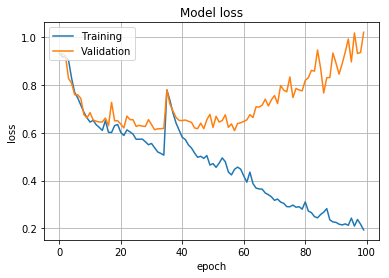

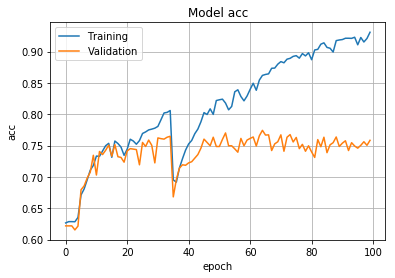

1464/1464 [==============================] - 2s 1ms/step
Test accuracy =  0.75273224011145
Test f1 score =  0.7471253818360933


,predicted_positive,predicted_neutral,predicted_negative
positive,140,34,50
neutral,30,163,132
negative,24,92,799


In [26]:
h1, model1=run(model1, **params)

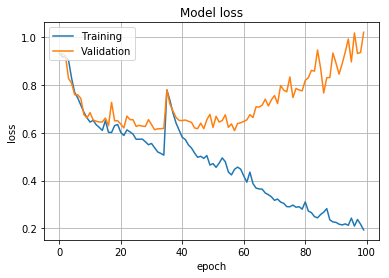

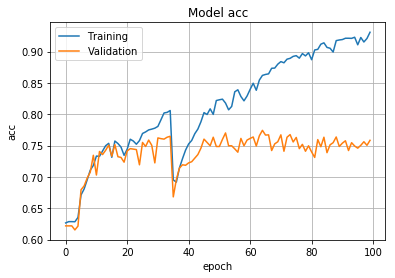

1464/1464 [==============================] - 2s 1ms/step
Test accuracy =  0.75273224011145
Test f1 score =  0.7471253818360933


,predicted_positive,predicted_neutral,predicted_negative
positive,140,34,50
neutral,30,163,132
negative,24,92,799


In [44]:
evaluate(h1, model1)

I run the model for 100 epochs and the final test result gives 0.75 accuracy and 0.74 f1 score, similar to the results I got in previous classifiers.

Also the history figures above show that the model has exhausted after about 50 epochs and got overfit on the training set. It couldn't further converge and fit well on test set.

### 4.3.2 Train model 2 - add more dropout layers

So I tried to add a few more dropout layers to prevent overfitting and rerun the model for 100 epochs:

In [27]:
def model_rnn_2(input_shape, word_to_vec_map, word_to_index):
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)
    
    X=LSTM(128, return_sequences=True)(embeddings)
    X=Dropout(0.5)(X)

    X=LSTM(128, return_sequences=False)(X)
    X=Dropout(0.5)(X)
    
    X=Dropout(0.5)(X)
    X=BatchNormalization()(X)
    X=Dropout(0.5)(X)
    
    X=Dense(512)(X)
    X=Activation('relu')(X)
    
    X=Dropout(0.5)(X)
    X=BatchNormalization()(X)
    X=Dropout(0.5)(X)

    X=Dense(3)(X)
    X=Activation('softmax')(X)
    
    model = Model(inputs=sentence_indices, outputs=X)    
    return model

In [28]:
model2=model_rnn_2((maxLen,), word_to_vec_map, word_to_index)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 89)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 89, 50)            20000050  
_________________________________________________________________
lstm_3 (LSTM)                (None, 89, 128)           91648     
_________________________________________________________________
dropout_3 (Dropout)          (None, 89, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
__________

In [31]:
h2, model2=run(model2, **params)

Train on 10540 samples, validate on 2636 samples
Epoch 1/100
10540/10540 [==============================] - 46s 4ms/step - loss: 1.5207 - acc: 0.4110 - val_loss: 1.0147 - val_acc: 0.6214
Epoch 2/100
10540/10540 [==============================] - 43s 4ms/step - loss: 1.1766 - acc: 0.5213 - val_loss: 1.2707 - val_acc: 0.3596
Epoch 3/100
10540/10540 [==============================] - 44s 4ms/step - loss: 1.0000 - acc: 0.5933 - val_loss: 0.9995 - val_acc: 0.6351
Epoch 4/100
10540/10540 [==============================] - 43s 4ms/step - loss: 0.9802 - acc: 0.5958 - val_loss: 0.9508 - val_acc: 0.6214
Epoch 5/100
10540/10540 [==============================] - 44s 4ms/step - loss: 0.9614 - acc: 0.6064 - val_loss: 0.9420 - val_acc: 0.6214
Epoch 6/100
10540/10540 [==============================] - 44s 4ms/step - loss: 0.9476 - acc: 0.6150 - val_loss: 0.9557 - val_acc: 0.6214
Epoch 7/100
10540/10540 [==============================] - 44s 4ms/step - loss: 0.9443 - acc: 0.6197 - val_loss: 0.9443 - v

10540/10540 [==============================] - 44s 4ms/step - loss: 0.2120 - acc: 0.9289 - val_loss: 1.1722 - val_acc: 0.7314
Epoch 60/100
10540/10540 [==============================] - 44s 4ms/step - loss: 0.2065 - acc: 0.9338 - val_loss: 1.3097 - val_acc: 0.7234
Epoch 61/100
10540/10540 [==============================] - 45s 4ms/step - loss: 0.2016 - acc: 0.9361 - val_loss: 1.4200 - val_acc: 0.7341
Epoch 62/100
10540/10540 [==============================] - 44s 4ms/step - loss: 0.1915 - acc: 0.9398 - val_loss: 1.1224 - val_acc: 0.7253
Epoch 63/100
10540/10540 [==============================] - 44s 4ms/step - loss: 0.1747 - acc: 0.9454 - val_loss: 1.2771 - val_acc: 0.7215
Epoch 64/100
10540/10540 [==============================] - 44s 4ms/step - loss: 0.1820 - acc: 0.9436 - val_loss: 1.7291 - val_acc: 0.7386
Epoch 65/100
10540/10540 [==============================] - 44s 4ms/step - loss: 0.2115 - acc: 0.9312 - val_loss: 0.9267 - val_acc: 0.7215
Epoch 66/100
10540/10540 [==============

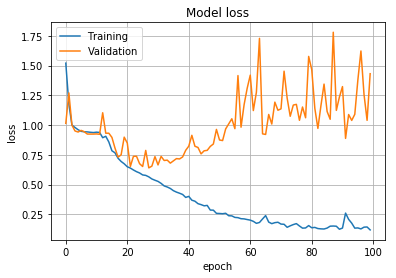

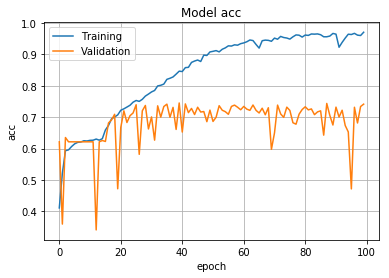

1464/1464 [==============================] - 2s 1ms/step
Test accuracy =  0.7349726775956285
Test f1 score =  0.7370564742273208


,predicted_positive,predicted_neutral,predicted_negative
positive,115,63,46
neutral,18,203,104
negative,18,139,758


In [45]:
evaluate(h2, model2)

However, it didn't improve the performance much. Also as the history shows, it starts to overfit since about 30 epochs. It's meaningless for me to run even further.

### 4.3.3 Train model 3 - enable embedding layer training

To better train the model I modified the model2 to enable it to re-train the embedding layer. Considering it will add a large amount of parameters to train, I run for only 30 epochs first:

In [33]:
def model_rnn_3(input_shape, word_to_vec_map, word_to_index):
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index, trainable=True)
    embeddings = embedding_layer(sentence_indices)
    
    X=LSTM(128, return_sequences=True)(embeddings)
    X=Dropout(0.5)(X)

    X=LSTM(128, return_sequences=False)(X)
    X=Dropout(0.5)(X)
    
    X=Dropout(0.5)(X)
    X=BatchNormalization()(X)
    X=Dropout(0.5)(X)
    
    X=Dense(512)(X)
    X=Activation('relu')(X)
    
    X=Dropout(0.5)(X)
    X=BatchNormalization()(X)
    X=Dropout(0.5)(X)

    X=Dense(3)(X)
    X=Activation('softmax')(X)
    
    model = Model(inputs=sentence_indices, outputs=X)    
    return model

In [34]:
model3=model_rnn_3((maxLen,), word_to_vec_map, word_to_index)
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 89)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 89, 50)            20000050  
_________________________________________________________________
lstm_5 (LSTM)                (None, 89, 128)           91648     
_________________________________________________________________
dropout_9 (Dropout)          (None, 89, 128)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
__________

In [35]:
params_30=params
params_30['epochs']=30
h3, model3=run(model3, **params_30)

Train on 10540 samples, validate on 2636 samples
Epoch 1/30
10540/10540 [==============================] - 71s 7ms/step - loss: 1.5660 - acc: 0.4162 - val_loss: 0.9473 - val_acc: 0.6214
Epoch 2/30
10540/10540 [==============================] - 67s 6ms/step - loss: 1.1892 - acc: 0.5033 - val_loss: 0.9492 - val_acc: 0.6214
Epoch 3/30
10540/10540 [==============================] - 68s 6ms/step - loss: 1.0540 - acc: 0.5477 - val_loss: 0.9563 - val_acc: 0.6214
Epoch 4/30
10540/10540 [==============================] - 67s 6ms/step - loss: 0.9742 - acc: 0.5861 - val_loss: 0.9597 - val_acc: 0.6214
Epoch 5/30
10540/10540 [==============================] - 67s 6ms/step - loss: 0.9368 - acc: 0.6075 - val_loss: 0.8541 - val_acc: 0.6457
Epoch 6/30
10540/10540 [==============================] - 68s 6ms/step - loss: 0.8183 - acc: 0.6327 - val_loss: 0.7794 - val_acc: 0.6847
Epoch 7/30
10540/10540 [==============================] - 67s 6ms/step - loss: 0.7635 - acc: 0.6464 - val_loss: 0.8306 - val_acc:

Run for another 30 epochs:

In [41]:
h3, model3=run(model3, **params_30)

Train on 10540 samples, validate on 2636 samples
Epoch 1/30
10540/10540 [==============================] - 72s 7ms/step - loss: 0.3059 - acc: 0.9116 - val_loss: 0.8638 - val_acc: 0.7508
Epoch 2/30
10540/10540 [==============================] - 67s 6ms/step - loss: 0.2901 - acc: 0.9156 - val_loss: 0.8287 - val_acc: 0.7409
Epoch 3/30
10540/10540 [==============================] - 68s 6ms/step - loss: 0.2800 - acc: 0.9159 - val_loss: 0.8516 - val_acc: 0.7595
Epoch 4/30
10540/10540 [==============================] - 68s 6ms/step - loss: 0.3168 - acc: 0.9019 - val_loss: 0.8340 - val_acc: 0.6889
Epoch 5/30
10540/10540 [==============================] - 68s 6ms/step - loss: 0.2839 - acc: 0.9171 - val_loss: 0.9168 - val_acc: 0.7583
Epoch 6/30
10540/10540 [==============================] - 68s 6ms/step - loss: 0.2712 - acc: 0.9199 - val_loss: 0.8346 - val_acc: 0.7280
Epoch 7/30
10540/10540 [==============================] - 67s 6ms/step - loss: 0.3330 - acc: 0.8921 - val_loss: 0.8994 - val_acc:

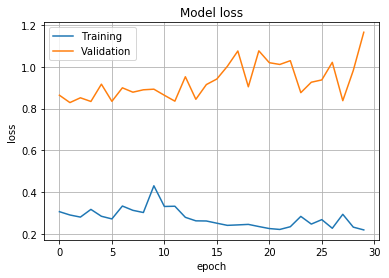

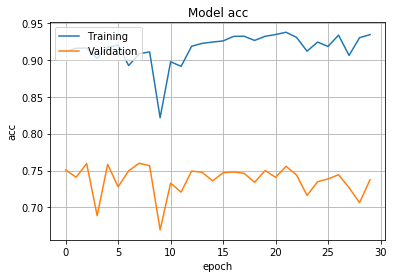

1464/1464 [==============================] - 2s 1ms/step
Test accuracy =  0.7233606560634134
Test f1 score =  0.7166624815533406


,predicted_positive,predicted_neutral,predicted_negative
positive,74,98,52
neutral,9,200,116
negative,4,126,785


In [46]:
evaluate(h3, model3)

Compared the 3 models above, the first one seems to perform better and yields 0.75 test accuracy and 0.74 test f1 score. The result is decent but running the LSTM model is quite computively expensive. Logistic regression, gradient boosting or random forest can be good alternatives.